<a href="https://colab.research.google.com/github/FrederickMappin/alphagenomeEZ/blob/main/alphagenomeEZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://raw.githubusercontent.com/FrederickMappin/alphagenomeEZ/main/icon1.png" height="200" align="right" style="height:240px">

# **alphagenomeEZ v0.9.0: Making alphagenome accessible to all**


AlphaGenomeEZ is a simplified implementation of the [google-deepmind/alphagenome](https://github.com/google-deepmind/alphagenome) meant to make the genome accessible to everyone.

For more details, see <a href="#Instructions">bottom</a> of the notebook and checkout the [AlphaGenomeEZ GitHub](https://github.com/sokrypton/ColabFold).

The offical colab notebook from [google-deepmind/alphagenome](https://colab.research.google.com/github/google-deepmind/alphagenome/blob/main/colabs/quick_start.ipynb#scrollTo=TZbfcADGkYVu)


Versions History:

Notebook Developer : [FrederickMappin](https://github.com/FrederickMappin)

Required API key can be obtained:[Get API key](https://deepmind.google.com/science/alphagenome/)


# **STEP 1. REQUIRED SET-UP**

In [317]:
# @title Install AlphaGenome

# @markdown Run this cell to install AlphaGenome.
from IPython.display import clear_output
! pip install alphagenome
clear_output()
from alphagenome import colab_utils
from alphagenome.models import dna_client
from google.colab import data_table
import pandas as pd

In [318]:
# @title Imports
# @markdown Import required  Libraries
from alphagenome import colab_utils
from alphagenome.data import gene_annotation
from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.interpretation import ism
from alphagenome.models import dna_client
from alphagenome.models import variant_scorers
from alphagenome.visualization import plot_components
import matplotlib.pyplot as plt
import pandas as pd

In [319]:
# @title API Key Input
# @markdown Alphagenome require API key to use. Provide key throught Google Colab Secrets Key [ALPHA_GENOME_API_KEY] or Directly.
import getpass
import os

api_key_option = "API KEY: Secrets" # @param ["API KEY: Secrets", "Enter API Key Directly"]

if api_key_option == "API KEY: Secrets":
  from google.colab import userdata
  api_key = userdata.get('ALPHA_GENOME_API_KEY')
elif api_key_option == "Enter API Key Directly":
  api_key = getpass.getpass("Enter your API Key value: ")
  os.environ["ALPHA_GENOME_API_KEY"] = api_key

dna_model = dna_client.create(api_key)

# **STEP 2. SELECT CELL OR TISSUE TYPES**

In [320]:
# @title Find Ontology Terms of Interest

# @markdown Click Filter on the upper right hand side of the interactive dataframe and type a cell or tissue name like "brain" into the Search by all fields box to find the ontology_curie term corresponding to a tissue and output type of interest:
from alphagenome import colab_utils
from alphagenome.models import dna_client
from google.colab import data_table
import pandas as pd

data_table.enable_dataframe_formatter()
output_metadata = dna_model.output_metadata(
    dna_client.Organism.HOMO_SAPIENS
).concatenate()

output_metadata

,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,data_source,endedness,genetically_modified,output_type,gtex_tissue,histone_mark,transcription_factor
0,CL:0000084 ATAC-seq,.,ATAC-seq,CL:0000084,T-cell,primary_cell,adult,encode,paired,False,OutputType.ATAC,NaN,NaN,NaN
1,CL:0000100 ATAC-seq,.,ATAC-seq,CL:0000100,motor neuron,in_vitro_differentiated_cells,adult,encode,paired,False,OutputType.ATAC,NaN,NaN,NaN
2,CL:0000236 ATAC-seq,.,ATAC-seq,CL:0000236,B cell,primary_cell,adult,encode,paired,False,OutputType.ATAC,NaN,NaN,NaN
3,CL:0000623 ATAC-seq,.,ATAC-seq,CL:0000623,natural killer cell,primary_cell,adult,encode,paired,False,OutputType.ATAC,NaN,NaN,NaN
4,CL:0000624 ATAC-seq,.,ATAC-seq,CL:0000624,"CD4-positive, alpha-beta T cell",primary_cell,adult,encode,paired,False,OutputType.ATAC,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,ENCSR182QNJ,-,PRO-cap,EFO:0001099,Caco-2,cell_line,NaN,encode,NaN,False,OutputType.PROCAP,NaN,NaN,NaN
8,ENCSR740IPL,-,PRO-cap,EFO:0002067,K562,cell_line,NaN,encode,NaN,False,OutputType.PROCAP,NaN,NaN,NaN
9,ENCSR797DEF,-,PRO-cap,EFO:0002819,Calu3,cell_line,NaN,encode,NaN,False,OutputType.PROCAP,NaN,NaN,NaN
10,ENCSR801ECP,-,PRO-cap,CL:0002618,endothelial cell of umbilical vein,primary_cell,NaN,encode,NaN,False,OutputType.PROCAP,NaN,NaN,NaN


In [321]:
# @title Create Ontology List
# @markdown ### Enter cell or tissue types ontology_curie term (comma-separated):
cell_tissue_input = "  UBERON:0000317,     UBERON:0001155,     UBERON:0001157,     UBERON:0001159" #@param {type:"string"}
cell_tissue_list = [item.strip() for item in cell_tissue_input.split(',') if item.strip()]

# --- Validation against output_metadata ---
print("\nValidating entered cell or tissue types against output_metadata:")
valid_cell_tissue = []
invalid_cell_tissue = []

# Assuming output_metadata DataFrame is available from a previous cell
if 'output_metadata' in locals():
    for item in cell_tissue_list:
        if (output_metadata['ontology_curie'].astype(str).str.contains(item, case=False).any() or
            output_metadata['name'].astype(str).str.contains(item, case=False).any()):
            valid_cell_tissue.append(item)
        else:
            invalid_cell_tissue.append(item)

    if valid_cell_tissue:
        print(f"Valid cell or tissue types found in metadata: {valid_cell_tissue}")
    if invalid_cell_tissue:
        print(f"Invalid cell or tissue types not found in metadata: {invalid_cell_tissue}")
    if not cell_tissue_list:
        print("No cell or tissue types entered for validation.")
else:
    print("output_metadata DataFrame not found. Cannot perform validation.")
# --- End of Validation ---


Validating entered cell or tissue types against output_metadata:
Valid cell or tissue types found in metadata: ['UBERON:0000317', 'UBERON:0001155', 'UBERON:0001157', 'UBERON:0001159']







# **STEP 3. SELECT GENE OR INTERVAL**

In [322]:
# @title Define Genomic Interval or Gene  and Resize
from alphagenome.data import genome
from alphagenome.data import gene_annotation
from alphagenome.models import dna_client
import pandas as pd

# The GTF file contains information on the location of all transcripts.
# Note that we use genome assembly hg38 for human.
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

# Set up transcript extractors using the information in the GTF file.
gtf_transcripts = gene_annotation.filter_protein_coding(gtf)
gtf_transcripts = gene_annotation.filter_to_longest_transcript(gtf_transcripts)
transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcripts)


#@markdown ### Choose how to define the genomic interval:
interval_definition_method = "Enter Coordinates" #@param ["Enter Coordinates", "Enter Gene Symbol"]

#@markdown ### Enter Interval Coordinates (if "Enter Coordinates" is selected):
chromosome = "chr22" #@param {type:"string"}
start = 36150498  #@param {type:"integer"}
end = 36252898 #@param {type:"integer"}

#@markdown ### Enter Gene Symbol (if "Enter Gene Symbol" is selected):
gene_symbol = "CYP2B6" #@param {type:"string"}

#@markdown ### Select Resize Length:
resize_length_option = "SEQUENCE_LENGTH_1MB" #@param ["SEQUENCE_LENGTH_2KB", "SEQUENCE_LENGTH_16KB", "SEQUENCE_LENGTH_100KB", "SEQUENCE_LENGTH_500KB", "SEQUENCE_LENGTH_1MB"]

interval = None # Initialize interval to None

# Define the interval based on the selected method and perform initial validation
if interval_definition_method == "Enter Coordinates":
  # Basic validation for coordinates
  if not chromosome or start is None or end is None:
    print("Error: Please provide chromosome, start, and end coordinates.")
  elif start >= end:
    print("Error: Start coordinate must be less than end coordinate.")
  # Validate chromosome against GTF data
  elif chromosome not in gtf['Chromosome'].unique():
      print(f"Error: Chromosome '{chromosome}' not found in the GTF data.")
  else:
    try:
      my_interval = genome.Interval(chromosome=chromosome, start=start, end=end)
      interval = my_interval
      print(f"Coordinate interval defined: {interval}")
    except Exception as e:
      print(f"Error creating interval from coordinates: {e}")

elif interval_definition_method == "Enter Gene Symbol":
  if not gene_symbol:
    print("Error: Please provide a gene symbol.")
  else:
    try:
      interval = gene_annotation.get_gene_interval(gtf, gene_symbol=gene_symbol)
      print(f"Gene interval defined for '{gene_symbol}': {interval}")
    except ValueError:
      print(f"Error: Gene symbol '{gene_symbol}' not found in the GTF data.")
    except Exception as e:
      print(f"An unexpected error occurred while getting gene interval: {e}")


# Resize the interval based on the selected option and validate within reference
if interval is not None:
  resize_map = {
      "SEQUENCE_LENGTH_2KB": dna_client.SEQUENCE_LENGTH_2KB,
      "SEQUENCE_LENGTH_16KB": dna_client.SEQUENCE_LENGTH_16KB,
      "SEQUENCE_LENGTH_100KB": dna_client.SEQUENCE_LENGTH_100KB,
      "SEQUENCE_LENGTH_500KB": dna_client.SEQUENCE_LENGTH_500KB,
      "SEQUENCE_LENGTH_1MB": dna_client.SEQUENCE_LENGTH_1MB,
  }
  selected_resize_length = resize_map.get(resize_length_option)

  if selected_resize_length is not None:
    try:
      resized_interval = interval.resize(selected_resize_length)

      # Display the resized interval regardless of whether it's within reference
      print("Resized interval:")
      display(resized_interval)

      # Validate if the resized interval is within the reference
      if resized_interval.within_reference():
          interval = resized_interval # Keep the resized interval if it's within reference
          print("Defined and resized interval is within reference.")
          # The interval is already displayed above
      else:
          print("Error: Resized interval is NOT within the reference.")
          # You could add more details here about why it's not within reference
          # depending on the capabilities of within_reference() or by adding checks.
          interval = None # Set interval to None if not within reference

    except Exception as e:
      print(f"Error resizing or checking within reference: {e}")
      interval = None # Set interval to None if an error occurs during resizing/checking

  else:
    print(f"Invalid resize length option selected: {resize_length_option}")
else:
  print("Interval could not be defined based on the provided input, or initial validation failed.")

Coordinate interval defined: chr22:36150498-36252898:.
Resized interval:


Interval(chromosome='chr22', start=35677410, end=36725986, strand='.', name='')

Defined and resized interval is within reference.





# **STEP 4. SELECT MODALITIES**

In [420]:
# @title Select Modalities
# @markdown ### Select Data Types (check multiple options):
RNA_SEQ = True #@param {type:"boolean"}
CAGE = True #@param {type:"boolean"}
PROCAP = True #@param {type:"boolean"}
DNASE = True #@param {type:"boolean"}
ATAC = True #@param {type:"boolean"}
CHIP_HISTONE = True #@param {type:"boolean"}
CHIP_TF = False #@param {type:"boolean"}
SPLICE_SITES = False #@param {type:"boolean"}
SPLICE_JUNCTIONS = False #@param {type:"boolean"}
SPLICE_SITE_USAGE = False #@param {type:"boolean"}
CONTACT_MAPS = False #@param {type:"boolean"}


# Collect selected data types
selected_data_types = []
data_type_options = {
    'RNA_SEQ': RNA_SEQ,
    'CAGE': CAGE,
    'PROCAP': PROCAP,
    'DNASE': DNASE,
    'ATAC': ATAC,
    'CHIP_HISTONE': CHIP_HISTONE,
    'CHIP_TF': CHIP_TF,
    'SPLICE_SITES': SPLICE_SITES,
    'SPLICE_JUNCTIONS': SPLICE_JUNCTIONS,
    'SPLICE_SITE_USAGE': SPLICE_SITE_USAGE,
    'CONTACT_MAPS': CONTACT_MAPS
}

for data_type, selected in data_type_options.items():
    if selected:
        selected_data_types.append(data_type)

print("Selected data types:", selected_data_types)
print(f"Number of selected data types: {len(selected_data_types)}")

Selected data types: ['RNA_SEQ', 'CAGE', 'PROCAP', 'DNASE', 'ATAC', 'CHIP_HISTONE']
Number of selected data types: 6


# **STEP 5. PREDICT AND VISUALIZE Go to Runtime -> Run cell and below**

In [454]:
# @title Predict Sequence

# Map selected data type strings to OutputType enums
output_type_map = {
    'ATAC': dna_client.OutputType.ATAC,
    'CAGE': dna_client.OutputType.CAGE,
    'DNASE': dna_client.OutputType.DNASE,
    'RNA_SEQ': dna_client.OutputType.RNA_SEQ,
    'CHIP_HISTONE': dna_client.OutputType.CHIP_HISTONE,
    'CHIP_TF': dna_client.OutputType.CHIP_TF,
    'SPLICE_SITES': dna_client.OutputType.SPLICE_SITES,
    'SPLICE_SITE_USAGE': dna_client.OutputType.SPLICE_SITE_USAGE,
    'SPLICE_JUNCTIONS': dna_client.OutputType.SPLICE_JUNCTIONS,
    'CONTACT_MAPS': dna_client.OutputType.CONTACT_MAPS,
    'PROCAP': dna_client.OutputType.PROCAP,
}

requested_outputs = [output_type_map[data_type] for data_type in selected_data_types if data_type in output_type_map]

# Ensure interval, valid_cell_tissue, and requested_outputs are available
if interval is None:
    print("Error: Genomic interval is not defined or valid. Please run the 'Define Genomic Interval and Resize' cell.")
elif not valid_cell_tissue:
    print("Error: No valid cell or tissue types selected. Please run the 'Create Ontology List' cell and ensure valid terms are entered.")
elif not requested_outputs:
     print("Error: No data types selected. Please run the 'Select Modalities' cell and select at least one data type.")
else:
    print(f"Requesting predictions for interval: {interval}")
    print(f"For ontology terms: {valid_cell_tissue}")
    print(f"For requested outputs: {requested_outputs}")

    output = dna_model.predict_interval(
        interval=interval,
        requested_outputs=requested_outputs,
        ontology_terms=valid_cell_tissue,
        # Assuming organism is not needed as it's handled by the interval or model
    )

    print("\nPrediction shapes:")
    # Print shapes for the requested outputs in the desired order
    ordered_data_types = [
        'RNA_SEQ', 'CAGE', 'PROCAP', 'DNASE', 'ATAC', 'CHIP_HISTONE',
        'CHIP_TF', 'SPLICE_SITES', 'SPLICE_JUNCTIONS', 'SPLICE_SITE_USAGE',
        'CONTACT_MAPS'
    ]

    for data_type_str in ordered_data_types:
        if data_type_str in selected_data_types: # Only process if the modality was selected
            output_enum = output_type_map.get(data_type_str)
            if output_enum:
                # Access the prediction results using the enum name (lowercase)
                prediction_data = getattr(output, output_enum.name.lower(), None)
                if prediction_data is not None: # Check if prediction_data is not None
                      print(f'{output_enum.name} predictions shape: {prediction_data.values.shape}')

                      # Display metadata for the track
                      if hasattr(prediction_data, 'metadata'):
                          print(f'{output_enum.name} metadata:')
                          display(prediction_data.metadata)
                      else:
                          print(f'No metadata found for {output_enum.name}')

                else:
                     print(f'Could not find prediction data for {output_enum.name}')
            else:
                print(f'Unknown selected data type: {data_type_str}')

Requesting predictions for interval: chr22:35677410-36725986:.
For ontology terms: ['UBERON:0000317', 'UBERON:0001155', 'UBERON:0001157', 'UBERON:0001159']
For requested outputs: [RNA_SEQ, CAGE, PROCAP, DNASE, ATAC, CHIP_HISTONE]

Prediction shapes:
RNA_SEQ predictions shape: (1048576, 10)
RNA_SEQ metadata:


,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,gtex_tissue,data_source,endedness,genetically_modified
0,UBERON:0000317 total RNA-seq,+,total RNA-seq,UBERON:0000317,colonic mucosa,tissue,adult,,encode,single,False
1,UBERON:0001157 total RNA-seq,+,total RNA-seq,UBERON:0001157,transverse colon,tissue,adult,,encode,paired,False
2,UBERON:0001159 polyA plus RNA-seq,+,polyA plus RNA-seq,UBERON:0001159,sigmoid colon,tissue,adult,,encode,paired,False
3,UBERON:0001159 total RNA-seq,+,total RNA-seq,UBERON:0001159,sigmoid colon,tissue,adult,,encode,paired,False
4,UBERON:0000317 total RNA-seq,-,total RNA-seq,UBERON:0000317,colonic mucosa,tissue,adult,,encode,single,False
5,UBERON:0001157 total RNA-seq,-,total RNA-seq,UBERON:0001157,transverse colon,tissue,adult,,encode,paired,False
6,UBERON:0001159 polyA plus RNA-seq,-,polyA plus RNA-seq,UBERON:0001159,sigmoid colon,tissue,adult,,encode,paired,False
7,UBERON:0001159 total RNA-seq,-,total RNA-seq,UBERON:0001159,sigmoid colon,tissue,adult,,encode,paired,False
8,UBERON:0001157 gtex Colon_Transverse polyA plu...,.,polyA plus RNA-seq,UBERON:0001157,transverse colon,tissue,adult,Colon_Transverse,gtex,paired,False
9,UBERON:0001159 gtex Colon_Sigmoid polyA plus R...,.,polyA plus RNA-seq,UBERON:0001159,sigmoid colon,tissue,adult,Colon_Sigmoid,gtex,paired,False


CAGE predictions shape: (1048576, 2)
CAGE metadata:


,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,data_source
0,hCAGE UBERON:0001155,+,hCAGE,UBERON:0001155,colon,tissue,fantom
1,hCAGE UBERON:0001155,-,hCAGE,UBERON:0001155,colon,tissue,fantom


PROCAP predictions shape: (1048576, 0)
PROCAP metadata:


,name,strand


DNASE predictions shape: (1048576, 3)
DNASE metadata:


,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,data_source,endedness,genetically_modified
0,UBERON:0000317 DNase-seq,.,DNase-seq,UBERON:0000317,colonic mucosa,tissue,child,encode,paired,False
1,UBERON:0001157 DNase-seq,.,DNase-seq,UBERON:0001157,transverse colon,tissue,adult,encode,paired,False
2,UBERON:0001159 DNase-seq,.,DNase-seq,UBERON:0001159,sigmoid colon,tissue,adult,encode,paired,False


ATAC predictions shape: (1048576, 3)
ATAC metadata:


,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,data_source,endedness,genetically_modified
0,UBERON:0000317 ATAC-seq,.,ATAC-seq,UBERON:0000317,colonic mucosa,tissue,adult,encode,paired,False
1,UBERON:0001157 ATAC-seq,.,ATAC-seq,UBERON:0001157,transverse colon,tissue,adult,encode,paired,False
2,UBERON:0001159 ATAC-seq,.,ATAC-seq,UBERON:0001159,sigmoid colon,tissue,adult,encode,paired,False


CHIP_HISTONE predictions shape: (8192, 16)
CHIP_HISTONE metadata:


,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,histone_mark,data_source,endedness,genetically_modified
0,UBERON:0000317 Histone ChIP-seq H3K27ac,.,Histone ChIP-seq,UBERON:0000317,colonic mucosa,tissue,adult,H3K27ac,encode,single,False
1,UBERON:0000317 Histone ChIP-seq H3K27me3,.,Histone ChIP-seq,UBERON:0000317,colonic mucosa,tissue,adult,H3K27me3,encode,single,False
2,UBERON:0000317 Histone ChIP-seq H3K36me3,.,Histone ChIP-seq,UBERON:0000317,colonic mucosa,tissue,adult,H3K36me3,encode,single,False
3,UBERON:0000317 Histone ChIP-seq H3K4me1,.,Histone ChIP-seq,UBERON:0000317,colonic mucosa,tissue,adult,H3K4me1,encode,single,False
4,UBERON:0000317 Histone ChIP-seq H3K4me3,.,Histone ChIP-seq,UBERON:0000317,colonic mucosa,tissue,adult,H3K4me3,encode,single,False
5,UBERON:0000317 Histone ChIP-seq H3K9ac,.,Histone ChIP-seq,UBERON:0000317,colonic mucosa,tissue,adult,H3K9ac,encode,single,False
6,UBERON:0001157 Histone ChIP-seq H3K27ac,.,Histone ChIP-seq,UBERON:0001157,transverse colon,tissue,adult,H3K27ac,encode,single,False
7,UBERON:0001157 Histone ChIP-seq H3K27me3,.,Histone ChIP-seq,UBERON:0001157,transverse colon,tissue,adult,H3K27me3,encode,single,False
8,UBERON:0001157 Histone ChIP-seq H3K36me3,.,Histone ChIP-seq,UBERON:0001157,transverse colon,tissue,adult,H3K36me3,encode,single,False
9,UBERON:0001157 Histone ChIP-seq H3K4me1,.,Histone ChIP-seq,UBERON:0001157,transverse colon,tissue,adult,H3K4me1,encode,single,False



Plotting interval: chr22:35850426-36552971


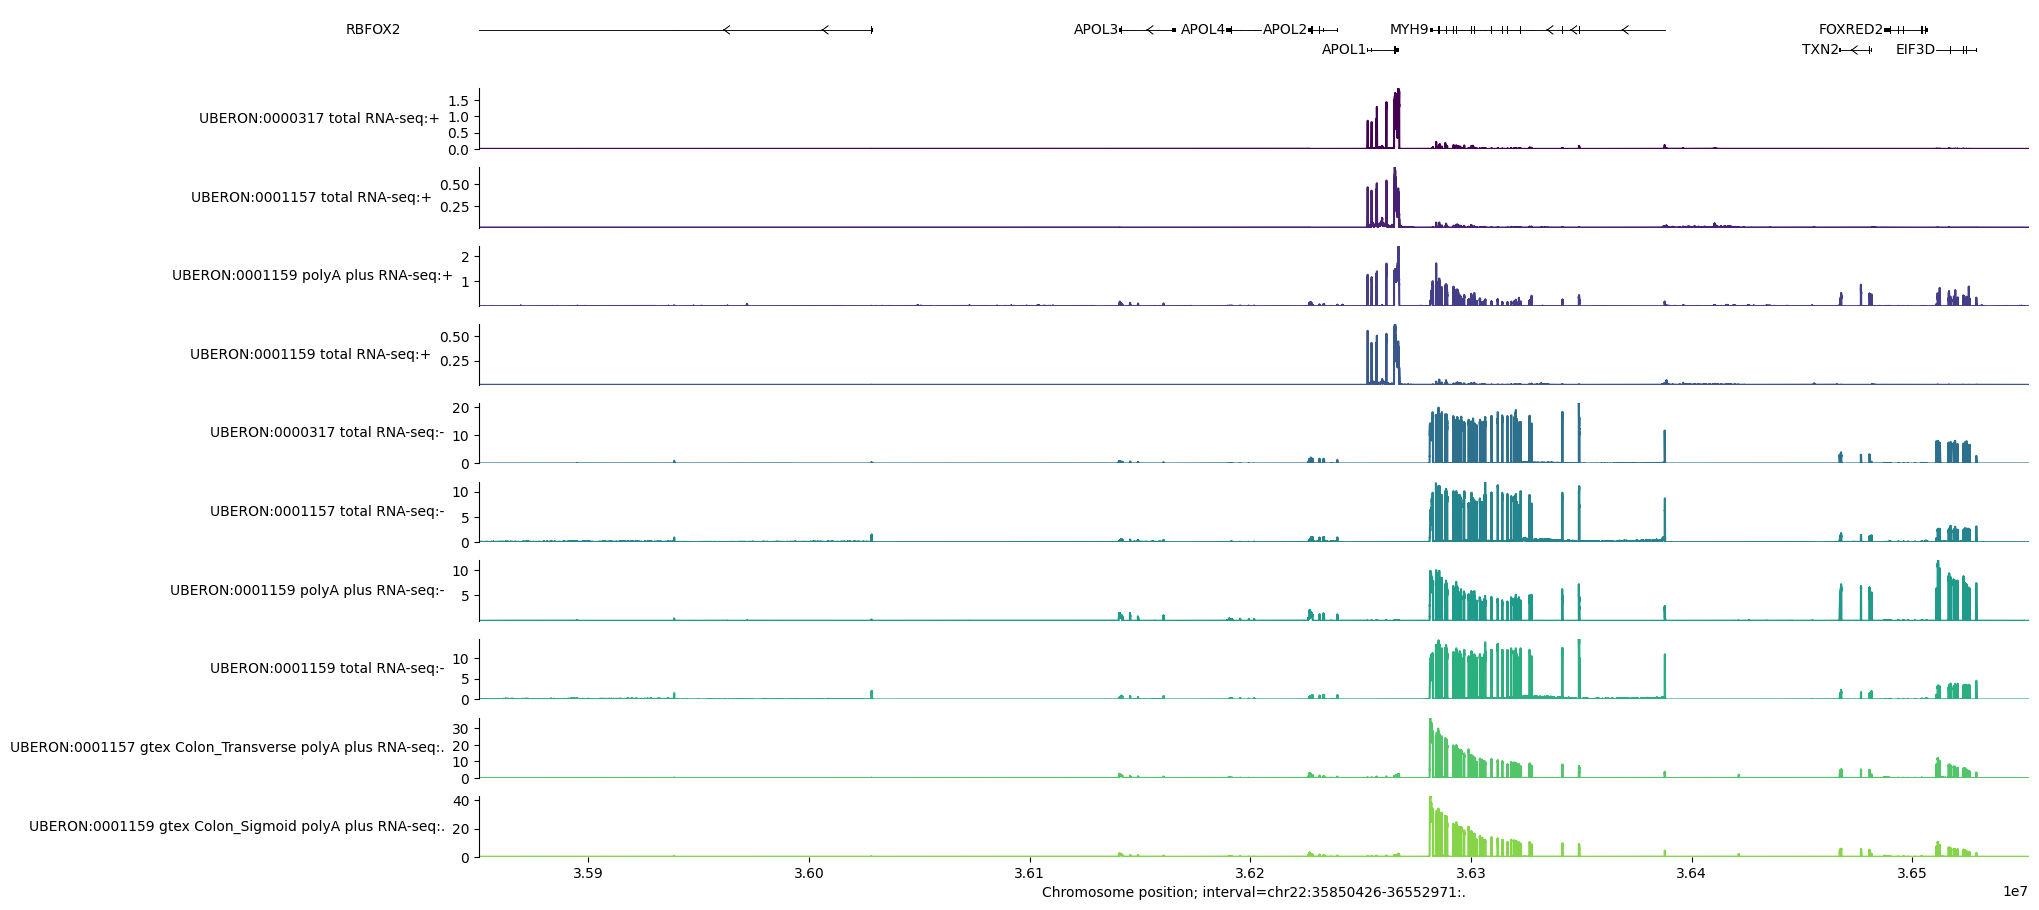

In [422]:
# @title RNA-SEQ PREDICTION
import matplotlib.pyplot as plt
from alphagenome.visualization import plot_components
from alphagenome.data import genome # Import genome module to create new intervals

longest_transcripts = transcript_extractor.extract(interval)

# Check if RNA_SEQ is selected in the "Select Modalities" cell
if 'RNA_SEQ' in selected_data_types:

    # Check if RNA_SEQ data is available in the output
    if hasattr(output, 'rna_seq') and output.rna_seq is not None:

        # Set max plot resize length to the width of the predicted interval (first dimension of shape)
        max_plot_resize_length = output.rna_seq.values.shape[0]

        #@markdown ### Select the zoom level (slide from 0 to 100%):
        zoom_percentage = 67 #@param {type:"slider", min:0, max:100, step:1}

        # Calculate the plot resize length based on the zoom percentage
        # Ensure we don't divide by zero if max_plot_resize_length is 0 (though unlikely)
        if max_plot_resize_length > 0:
            plot_resize_length = int((zoom_percentage / 100.0) * max_plot_resize_length)
        else:
            plot_resize_length = 0 # Or handle this case as appropriate

        # Ensure plot_resize_length is at least 1 for plotting purposes if max length is > 0
        if plot_resize_length == 0 and max_plot_resize_length > 0:
            plot_resize_length = 1
        elif max_plot_resize_length == 0:
            print("Warning: Predicted interval length is 0, cannot create plot.")
            plot_resize_length = 0 # Cannot plot if interval length is 0


        # Create a new interval for plotting, centered within the predicted interval
        # Only proceed if plot_resize_length is greater than 0
        if plot_resize_length > 0:
            predicted_interval = output.rna_seq.interval
            center = (predicted_interval.start + predicted_interval.end) // 2
            plot_start = center - plot_resize_length // 2
            plot_end = center + (plot_resize_length - plot_resize_length // 2) # Handle odd lengths

            # Ensure the new plot interval is within the bounds of the predicted interval
            plot_start = max(plot_start, predicted_interval.start)
            plot_end = min(plot_end, predicted_interval.end)

            # Create the plotting interval object (still needed for the plot function)
            plotting_interval = genome.Interval(
                chromosome=predicted_interval.chromosome,
                start=plot_start,
                end=plot_end,
                strand=predicted_interval.strand,
                name=predicted_interval.name # Keep the name if it exists
            )

            # Print the details of the plotting interval using plot_start and plot_end
            print(f"\nPlotting interval: {predicted_interval.chromosome}:{plot_start}-{plot_end}")


            plot_components.plot(
                components=[
                    plot_components.TranscriptAnnotation(
                        longest_transcripts, fig_height=0.1
                    ),
                    plot_components.Tracks(output.rna_seq),
                ],
                interval=plotting_interval, # Use the newly created plotting interval
            )

            plt.show()
        else:
            print("Plot not generated because plot_resize_length is 0.") # Message if plot length is 0
    else:
        print("RNA_SEQ prediction data is not available in the output.") # Message if RNA_SEQ data is not available
else:
    print("RNA_SEQ was not selected in STEP 4.") # Message if RNA_SEQ not selected


Plotting interval: chr22:35677410-36725986


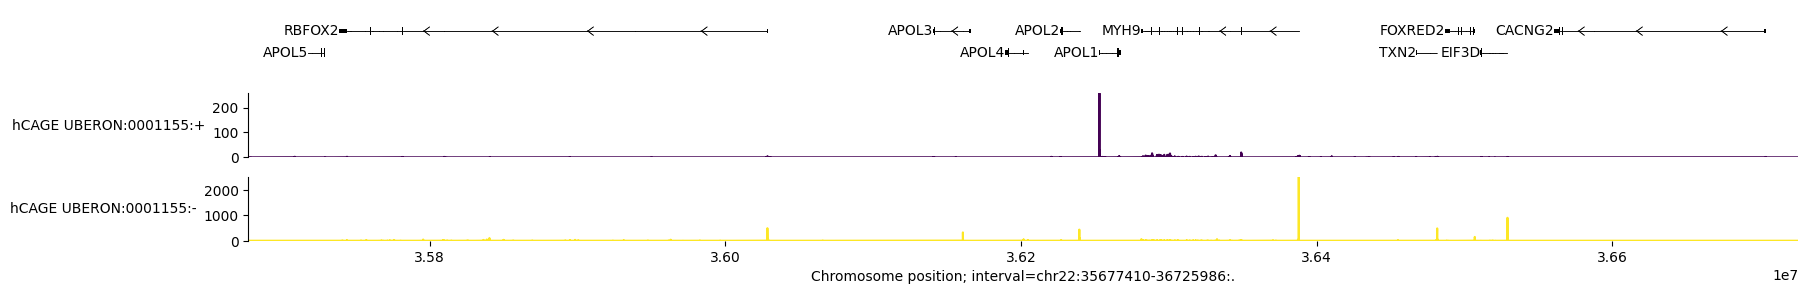

In [450]:
# @title CAGE PREDICTION

# Check if CAGE is selected in the "Select Modalities" cell
if 'CAGE' in selected_data_types:

    # Check if CAGE data is available in the output
    if hasattr(output, 'cage') and output.cage is not None:

        # Set max plot resize length to the width of the predicted interval (first dimension of shape)
        # Use the shape of the CAGE predictions for this cell
        max_plot_resize_length = output.cage.values.shape[0]

        #@markdown ### Select the zoom level (slide from 0 to 100%):
        zoom_percentage = 100 #@param {type:"slider", min:0, max:100, step:1}

        # Calculate the plot resize length based on the zoom percentage
        # Ensure we don't divide by zero if max_plot_resize_length is 0 (though unlikely)
        if max_plot_resize_length > 0:
            plot_resize_length = int((zoom_percentage / 100.0) * max_plot_resize_length)
        else:
            plot_resize_length = 0 # Or handle this case as appropriate

        # Ensure plot_resize_length is at least 1 for plotting purposes if max length is > 0
        if plot_resize_length == 0 and max_plot_resize_length > 0:
            plot_resize_length = 1
        elif max_plot_resize_length == 0:
            print("Warning: Predicted interval length is 0, cannot create plot.")


        # Create a new interval for plotting, centered within the predicted interval
        # Only proceed if plot_resize_length is greater than 0
        if plot_resize_length > 0:
            predicted_interval = output.cage.interval # Use CAGE interval
            center = (predicted_interval.start + predicted_interval.end) // 2
            plot_start = center - plot_resize_length // 2
            plot_end = center + (plot_resize_length - plot_resize_length // 2) # Handle odd lengths

            # Ensure the new plot interval is within the bounds of the predicted interval
            plot_start = max(plot_start, predicted_interval.start)
            plot_end = min(plot_end, predicted_interval.end)

            # Create the plotting interval object (still needed for the plot function)
            plotting_interval = genome.Interval(
                chromosome=predicted_interval.chromosome,
                start=plot_start,
                end=plot_end,
                strand=predicted_interval.strand,
                name=predicted_interval.name # Keep the name if it exists
            )

            # Print the details of the plotting interval using plot_start and plot_end
            print(f"\nPlotting interval: {predicted_interval.chromosome}:{plot_start}-{plot_end}")


            plot_components.plot(
                components=[
                    plot_components.TranscriptAnnotation(
                        longest_transcripts, fig_height=0.1
                    ),
                    plot_components.Tracks(output.cage), # Plot CAGE track
                ],
                interval=plotting_interval, # Use the newly created plotting interval
            )

            plt.show()
        else:
            print("Plot not generated because plot_resize_length is 0.") # Message if plot length is 0
    else:
        print("CAGE prediction data is not available in the output.") # Message if CAGE data is not available
else:
    print("CAGE was not selected in STEP 4.") # Message if CAGE not selected


Plotting interval: chr22:35677410-36725986


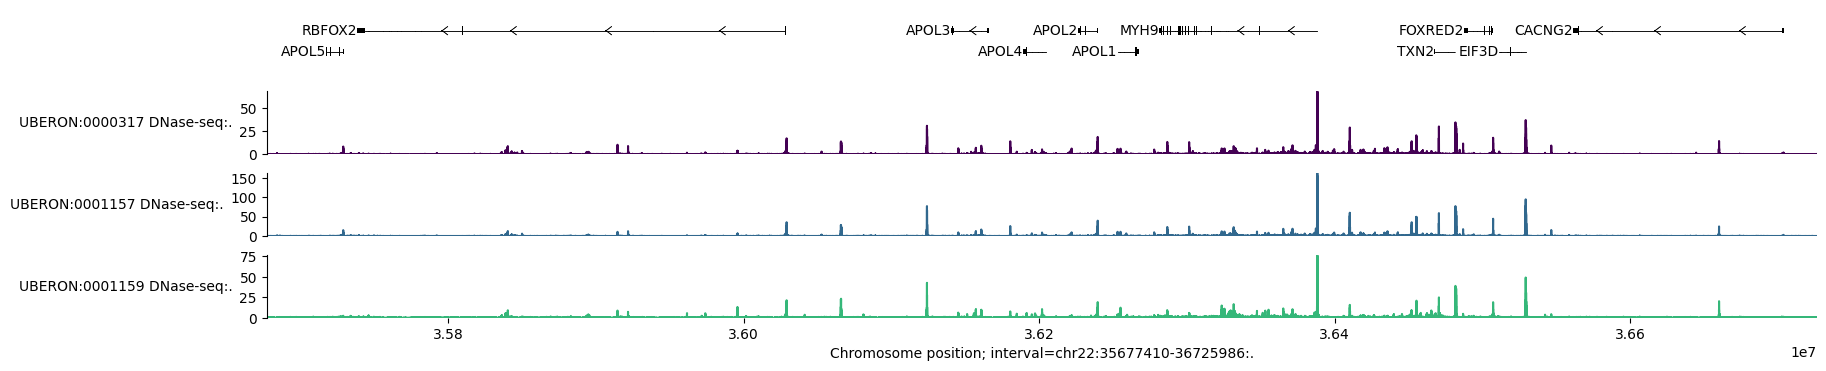

In [451]:
 # @title DNASE PREDICTION

# Check if DNASE is selected in the "Select Modalities" cell
if 'DNASE' in selected_data_types:

    # Check if DNASE data is available in the output
    if hasattr(output, 'dnase') and output.dnase is not None:

        # Set max plot resize length to the width of the predicted interval (first dimension of shape)
        # Use the shape of the DNASE predictions for this cell
        max_plot_resize_length = output.dnase.values.shape[0]

        #@markdown ### Select the zoom level (slide from 0 to 100%):
        zoom_percentage = 100 #@param {type:"slider", min:0, max:100, step:1}

        # Calculate the plot resize length based on the zoom percentage
        # Ensure we don't divide by zero if max_plot_resize_length is 0 (though unlikely)
        if max_plot_resize_length > 0:
            plot_resize_length = int((zoom_percentage / 100.0) * max_plot_resize_length)
        else:
            plot_resize_length = 0 # Or handle this case as appropriate

        # Ensure plot_resize_length is at least 1 for plotting purposes if max length is > 0
        if plot_resize_length == 0 and max_plot_resize_length > 0:
            plot_resize_length = 1
        elif max_plot_resize_length == 0:
            print("Warning: Predicted interval length is 0, cannot create plot.")


        # Create a new interval for plotting, centered within the predicted interval
        # Only proceed if plot_resize_length is greater than 0
        if plot_resize_length > 0:
            predicted_interval = output.dnase.interval # Use DNASE interval
            center = (predicted_interval.start + predicted_interval.end) // 2
            plot_start = center - plot_resize_length // 2
            plot_end = center + (plot_resize_length - plot_resize_length // 2) # Handle odd lengths

            # Ensure the new plot interval is within the bounds of the predicted interval
            plot_start = max(plot_start, predicted_interval.start)
            plot_end = min(plot_end, predicted_interval.end)

            # Create the plotting interval object (still needed for the plot function)
            plotting_interval = genome.Interval(
                chromosome=predicted_interval.chromosome,
                start=plot_start,
                end=plot_end,
                strand=predicted_interval.strand,
                name=predicted_interval.name # Keep the name if it exists
            )

            # Print the details of the plotting interval using plot_start and plot_end
            print(f"\nPlotting interval: {predicted_interval.chromosome}:{plot_start}-{plot_end}")


            plot_components.plot(
                components=[
                    plot_components.TranscriptAnnotation(
                        longest_transcripts, fig_height=0.1
                    ),
                    plot_components.Tracks(output.dnase), # Plot DNASE track
                ],
                interval=plotting_interval, # Use the newly created plotting interval
            )

            plt.show()
        else:
            print("Plot not generated because plot_resize_length is 0.") # Message if plot length is 0
    else:
        print("DNASE prediction data is not available in the output.") # Message if DNASE data is not available
else:
    print("DNASE was not selected in STEP 4.") # Message if DNASE not selected


Plotting interval: chr22:35677410-36725986


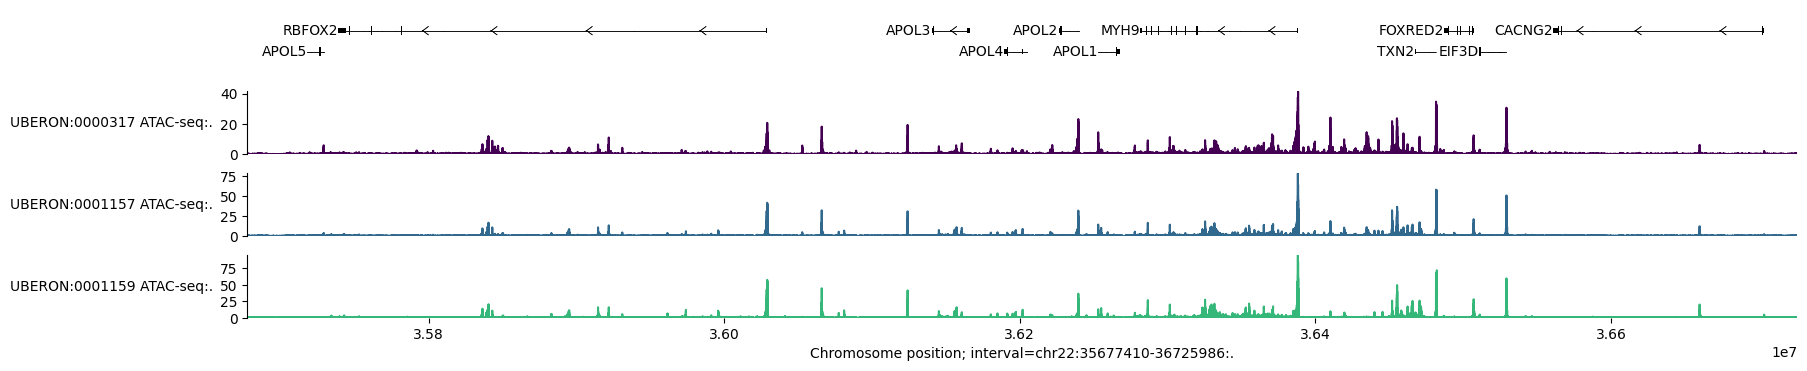

In [452]:
# @title ATAC PREDICTION
import matplotlib.pyplot as plt
from alphagenome.visualization import plot_components
from alphagenome.data import genome # Import genome module to create new intervals

# Assuming longest_transcripts is available from a previous cell

# Check if ATAC is selected in the "Select Modalities" cell
if 'ATAC' in selected_data_types:

    # Check if ATAC data is available in the output
    if hasattr(output, 'atac') and output.atac is not None:

        # Set max plot resize length to the width of the predicted interval (first dimension of shape)
        # Use the shape of the ATAC predictions for this cell
        max_plot_resize_length = output.atac.values.shape[0]

        #@markdown ### Select the zoom level (slide from 0 to 100%):
        zoom_percentage = 100 #@param {type:"slider", min:0, max:100, step:1}

        # Calculate the plot resize length based on the zoom percentage
        # Ensure we don't divide by zero if max_plot_resize_length is 0 (though unlikely)
        if max_plot_resize_length > 0:
            plot_resize_length = int((zoom_percentage / 100.0) * max_plot_resize_length)
        else:
            plot_resize_length = 0 # Or handle this case as appropriate

        # Ensure plot_resize_length is at least 1 for plotting purposes if max length is > 0
        if plot_resize_length == 0 and max_plot_resize_length > 0:
            plot_resize_length = 1
        elif max_plot_resize_length == 0:
            print("Warning: Predicted interval length is 0, cannot create plot.")


        # Create a new interval for plotting, centered within the predicted interval
        # Only proceed if plot_resize_length is greater than 0
        if plot_resize_length > 0:
            predicted_interval = output.atac.interval # Use ATAC interval
            center = (predicted_interval.start + predicted_interval.end) // 2
            plot_start = center - plot_resize_length // 2
            plot_end = center + (plot_resize_length - plot_resize_length // 2) # Handle odd lengths

            # Ensure the new plot interval is within the bounds of the predicted interval
            plot_start = max(plot_start, predicted_interval.start)
            plot_end = min(plot_end, predicted_interval.end)

            # Create the plotting interval object (still needed for the plot function)
            plotting_interval = genome.Interval(
                chromosome=predicted_interval.chromosome,
                start=plot_start,
                end=plot_end,
                strand=predicted_interval.strand,
                name=predicted_interval.name # Keep the name if it exists
            )

            # Print the details of the plotting interval using plot_start and plot_end
            print(f"\nPlotting interval: {predicted_interval.chromosome}:{plot_start}-{plot_end}")


            plot_components.plot(
                components=[
                    plot_components.TranscriptAnnotation(
                        longest_transcripts, fig_height=0.1
                    ),
                    plot_components.Tracks(output.atac), # Plot ATAC track
                ],
                interval=plotting_interval, # Use the newly created plotting interval
            )

            plt.show()
        else:
            print("Plot not generated because plot_resize_length is 0.") # Message if plot length is 0
    else:
        print("ATAC prediction data is not available in the output.") # Message if ATAC data is not available
else:
    print("ATAC was not selected in STEP 4.") # Message if ATAC not selected

Number of TSS intervals found within the original interval: 11
Reordered CHIP_HISTONE track data shape: (8192, 16)
Reordered CHIP_HISTONE interval width: 1048576

Plotting interval (Histone): chr22:36152546-36250850
Number of TSS intervals overlapping with the plotting interval: 3


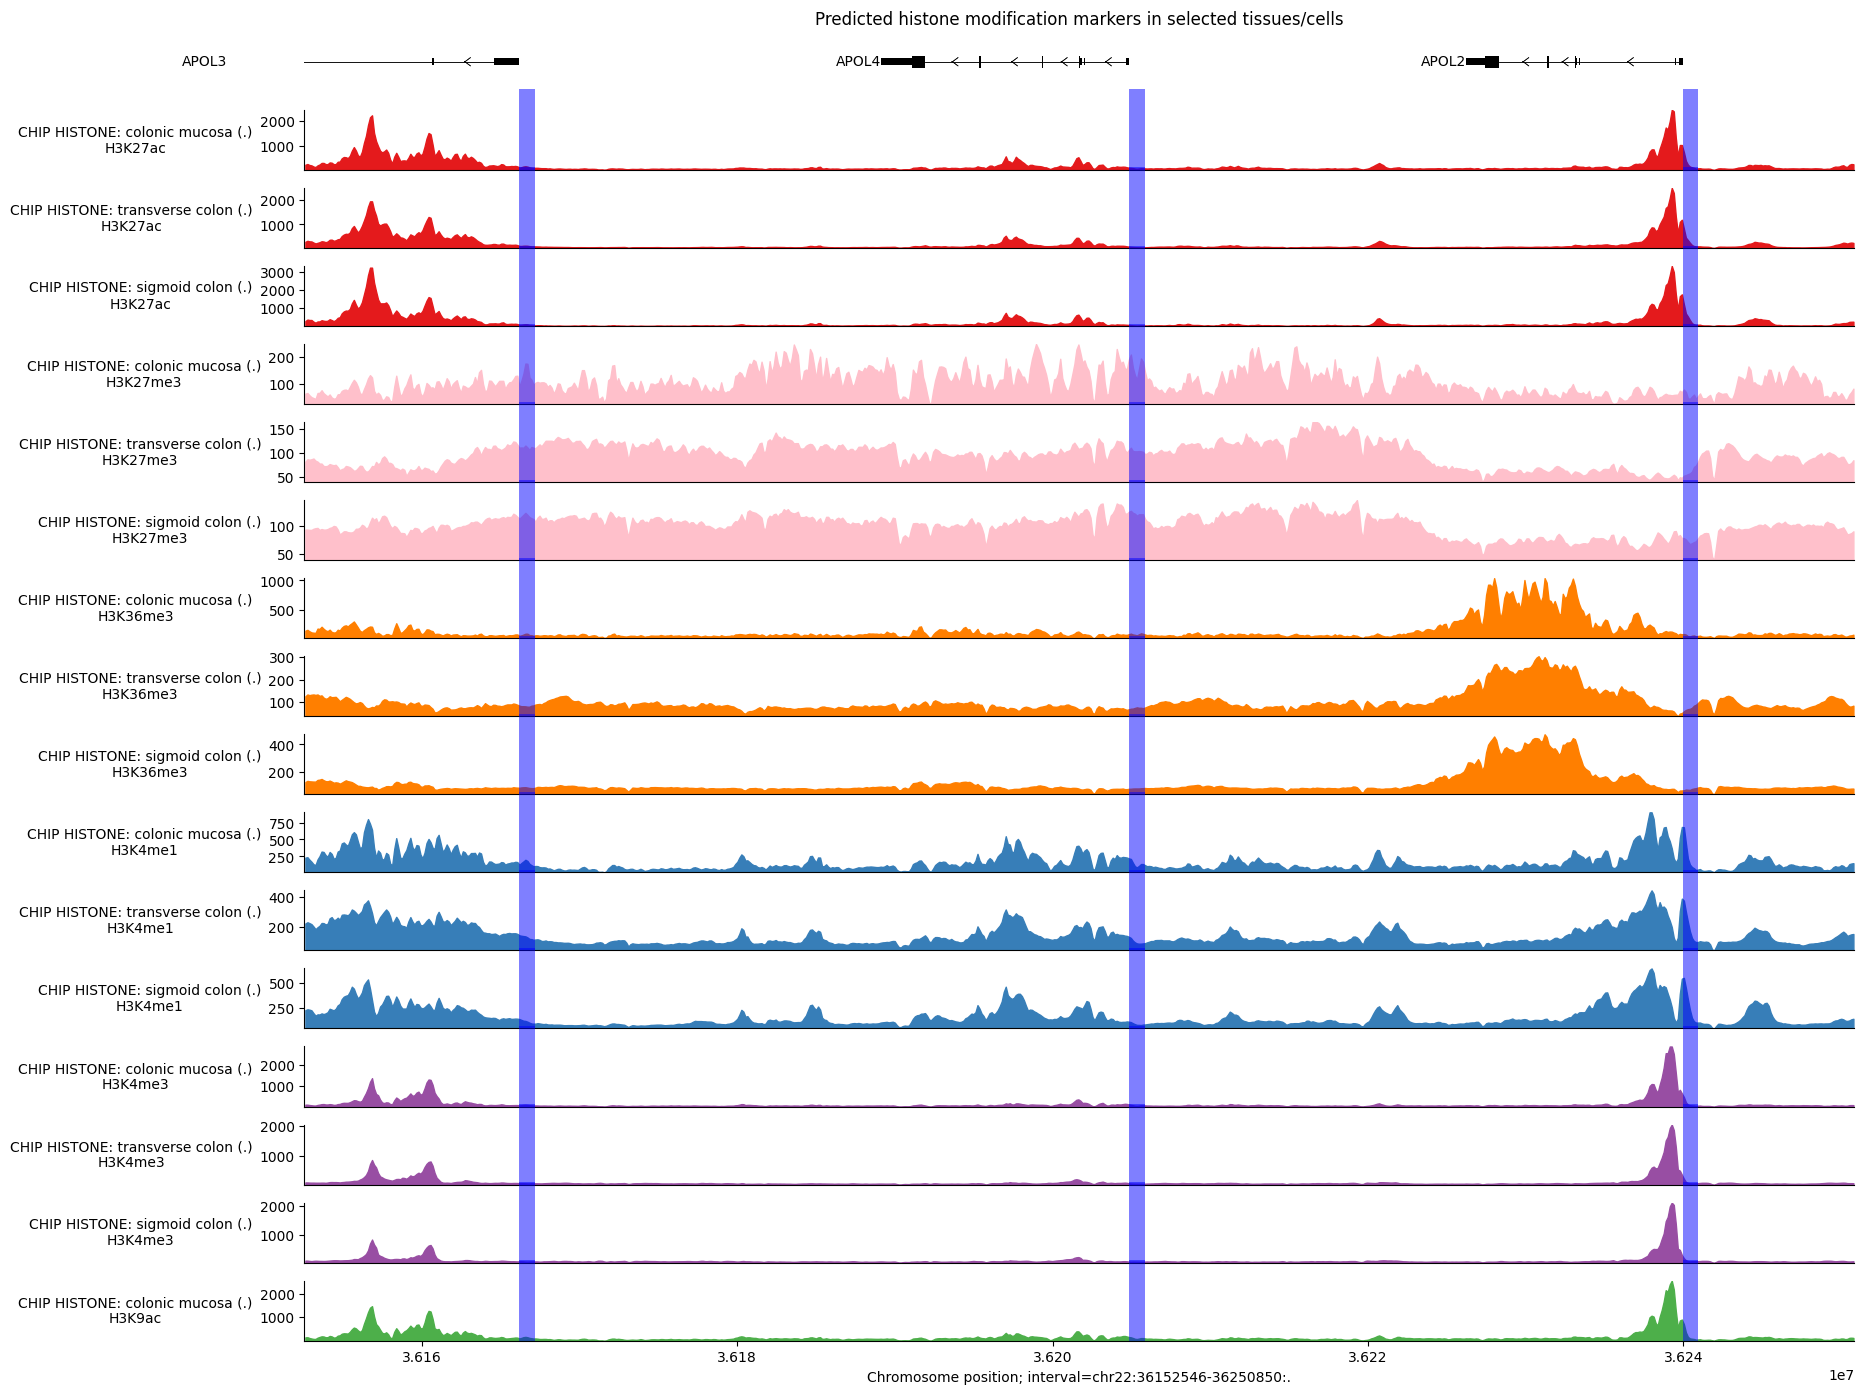

In [453]:
# @title CHIP HISTONE PREDICTION
import matplotlib.pyplot as plt
from alphagenome.visualization import plot_components
from alphagenome.data import genome # Import genome module to create new intervals

# Assuming longest_transcripts is available from a previous cell

# Check if CHIP_HISTONE is selected in the "Select Modalities" cell
if 'CHIP_HISTONE' in selected_data_types:

    # Ensure interval and valid_cell_tissue are available from previous cells
    if interval is None:
        print("Error: Genomic interval is not defined or valid. Please run the 'Define Genomic Interval and Resize' cell.")
    elif not valid_cell_tissue:
        print("Error: No valid cell or tissue types selected. Please run the 'Create Ontology List' cell and ensure valid terms are entered.")
    else:
        # Use the user's selected ontology terms (valid_cell_tissue)
        ontology_terms = valid_cell_tissue

        # Make predictions using the user's interval and selected ontology terms.
        # Requested outputs are specifically CHIP_HISTONE as in the original cell.
        # Store the output in a new variable to avoid overwriting the main 'output'
        histone_output = dna_model.predict_interval(
            interval=interval,
            requested_outputs={dna_client.OutputType.CHIP_HISTONE},
            ontology_terms=ontology_terms,
        )

        # Check if CHIP_HISTONE data is available in the output
        if hasattr(histone_output, 'chip_histone') and histone_output.chip_histone is not None:

            # Extract TSS - Similar to the provided snippet, ensure necessary data is available
            tss_as_intervals = [] # Initialize as empty
            # Ensure transcript_extractor and gtf_longest_transcript are available
            if 'transcript_extractor' in locals() and transcript_extractor is not None and 'gtf_longest_transcript' in locals() and gtf_longest_transcript is not None:
                try:
                    # Use transcript_extractor to get TSS from the gtf_transcripts
                    # Filter to protein_coding and longest transcripts first (already done to create gtf_longest_transcript)
                    # Directly extract TSS from gtf_longest_transcript
                    gtf_tss = gene_annotation.extract_tss(gtf_longest_transcript)

                    # Filter TSS to be within the original user-defined interval (for annotation pool)
                    if interval is not None:
                         tss_in_interval = gtf_tss[
                             (gtf_tss['Chromosome'] == interval.chromosome) &
                             (gtf_tss['Start'] >= interval.start) &
                             (gtf_tss['End'] <= interval.end)
                         ].copy() # Use .copy() to avoid SettingWithCopyWarning

                         tss_as_intervals = [
                             genome.Interval(
                                 chromosome=row['Chromosome'],
                                 start=row['Start'],
                                 end=row['End'] + 1000,  # Add extra 1Kb so the TSSs are visible.
                                 strand=row['Strand'],
                                 name=row['gene_name'] # Use gene_name for annotation
                             )
                             for _, row in tss_in_interval.iterrows()
                         ]
                         print(f"Number of TSS intervals found within the original interval: {len(tss_as_intervals)}")
                    else:
                         print("Interval is not defined, cannot filter TSS by interval for annotations.")


                except Exception as e:
                     print(f"Error creating tss_as_intervals: {e}")
                     tss_as_intervals = [] # Set to empty if creation fails
            else:
                print("Warning: 'transcript_extractor' or 'gtf_longest_transcript' not available. Cannot create TSS annotations.")


            # Reorder tracks based on histone mark using select_tracks_by_index as in snippet
            if histone_output.chip_histone.metadata is not None and not histone_output.chip_histone.metadata.empty:
                 # Filter metadata for the selected cell/tissue types before sorting/reordering
                 filtered_chip_histone_metadata = histone_output.chip_histone.metadata[
                     histone_output.chip_histone.metadata['ontology_curie'].isin(valid_cell_tissue)
                 ].copy()

                 if not filtered_chip_histone_metadata.empty:
                      # Get the indices of the filtered metadata, sorted by histone mark
                      sorted_filtered_indices = filtered_chip_histone_metadata.sort_values(by='histone_mark').index

                      # Use select_tracks_by_index on the original output, with the sorted filtered indices
                      # This should create a new TrackData object containing only the selected tracks,
                      # reordered and with an interval matching the original output.chip_histone
                      reordered_chip_histone = histone_output.chip_histone.select_tracks_by_index(
                          sorted_filtered_indices
                      )
                      print(f"Reordered CHIP_HISTONE track data shape: {reordered_chip_histone.values.shape}")
                      print(f"Reordered CHIP_HISTONE interval width: {reordered_chip_histone.interval.width}")


                 else:
                      print("No CHIP_HISTONE metadata found for the selected cell/tissue types after prediction.")
                      reordered_chip_histone = None # Cannot reorder if no metadata

            else:
                print("CHIP_HISTONE metadata not available or is empty in the prediction output.")
                reordered_chip_histone = None # Cannot reorder if no metadata


            # Define track colors as in snippet
            histone_to_color = {
                'H3K27AC': '#e41a1c',
                'H3K36ME3': '#ff7f00',
                'H3K4ME1': '#377eb8',
                'H3K4ME3': '#984ea3',
                'H3K9AC': '#4daf4a',
                'H3K27ME3': '#ffc0cb',
            }
            # Generate track colors based on the reordered metadata
            track_colors_list = []
            if reordered_chip_histone is not None:
                # Ensure all histone marks in the reordered metadata are in the color map
                for histone_mark in reordered_chip_histone.metadata['histone_mark'].str.upper().unique():
                    if histone_mark not in histone_to_color:
                        histone_to_color[histone_mark] = '#000000' # Default to black if not in map
                track_colors_list = (
                    reordered_chip_histone.metadata['histone_mark']
                    .map(lambda x: histone_to_color.get(x.upper(), '#000000'))
                    .values
                )
            else:
                 print("Reordered CHIP_HISTONE data not available to generate track colors.")


            #@markdown ### Select the zoom level (slide from 0 to 100%):
            zoom_percentage = 10 #@param {type:"slider", min:0, max:100, step:1}

            # Calculate the desired plot length based on the zoom percentage and total data points
            # Use the number of data points in the reordered data
            if reordered_chip_histone is not None and hasattr(reordered_chip_histone, 'values') and reordered_chip_histone.values.shape[0] > 0:
                 num_reordered_data_points = reordered_chip_histone.values.shape[0]
                 target_data_points = int((zoom_percentage / 100.0) * num_reordered_data_points)
                 # Ensure the target data points is a multiple of 128 and at least 128 (if possible)
                 plot_data_points_length = max(128, (target_data_points // 128) * 128) if target_data_points > 0 else 0
                 # Ensure plot_data_points_length does not exceed the available data points
                 plot_data_points_length = min(plot_data_points_length, num_reordered_data_points)

                 # Calculate the corresponding genomic length based on the resolution (128 bp per data point)
                 plot_resize_length = plot_data_points_length * 128 # Assuming 128 bp resolution

            else:
                 print("Warning: Reordered CHIP_HISTONE prediction data not available or has zero length. Cannot calculate plot length.")
                 plot_resize_length = 0 # Cannot plot if data has zero length


            # Create a new interval for plotting, centered within the reordered data's interval
            # Only proceed if plot_resize_length is greater than 0 and the reordered data interval is valid
            if plot_resize_length > 0 and reordered_chip_histone is not None and reordered_chip_histone.interval is not None:
                 predicted_interval_for_centering = reordered_chip_histone.interval # Use the reordered data's interval for centering
                 center = (predicted_interval_for_centering.start + predicted_interval_for_centering.end) // 2
                 plot_start = center - plot_resize_length // 2
                 plot_end = center + (plot_resize_length - plot_resize_length // 2) # Handle odd lengths

                 # Ensure the new plot interval is within the bounds of the reordered data's interval
                 plot_start = max(plot_start, predicted_interval_for_centering.start)
                 plot_end = min(plot_end, predicted_interval_for_centering.end)


                 # Create the plotting interval object
                 plotting_interval_histone = genome.Interval(
                     chromosome=predicted_interval_for_centering.chromosome,
                     start=plot_start,
                     end=plot_end,
                     strand=predicted_interval_for_centering.strand,
                     name=predicted_interval_for_centering.name
                 )

                 print(f"\nPlotting interval (Histone): {plotting_interval_histone.chromosome}:{plot_start}-{plot_end}")

                 # Build plot.
                 plot_components_list = [
                     plot_components.TranscriptAnnotation(longest_transcripts),
                     plot_components.Tracks(
                         tdata=reordered_chip_histone, # Use the reordered data
                         ylabel_template=(
                             'CHIP HISTONE: {biosample_name} ({strand})\n{histone_mark}'
                         ),
                         filled=True,
                         track_colors=track_colors_list, # Use the generated colors
                     ),
                 ]

                # Define annotations list as in snippet
                 annotations_list = []
                # Add TSS annotations if available and not empty
                 if tss_as_intervals:
                     annotations_list.append(
                         plot_components.IntervalAnnotation(
                             tss_as_intervals, alpha=0.5, colors='blue' # Use blue color for TSS
                         )
                     )
                     # Also print how many TSS are in the actual plotting interval for clarity
                     # Need a plotting interval to check overlap
                     if plotting_interval_histone is not None: # Use the new plotting interval for this check
                          overlapping_tss_plot = [
                               tss for tss in tss_as_intervals
                               if tss.overlaps(plotting_interval_histone) # Check overlap with the plotting interval
                          ]
                          print(f"Number of TSS intervals overlapping with the plotting interval: {len(overlapping_tss_plot)}")


                 plot = plot_components.plot(
                     components=plot_components_list,
                     interval=plotting_interval_histone, # Use the newly created plotting interval
                     annotations=annotations_list, # Pass annotations
                     despine_keep_bottom=True,
                     title='Predicted histone modification markers in selected tissues/cells', # Updated title
                 )
                 plt.show()
            elif reordered_chip_histone is None:
                print("Plot not generated because reordered CHIP_HISTONE data is not available.")
            else:
                print("Plot not generated because plot_resize_length is 0 or reordered data interval is invalid.")


        else:
            print("CHIP_HISTONE data is not available in the prediction output.")
else:
    print("CHIP_HISTONE was not selected in STEP 4.")

In [427]:
#@title CHIP_TF

In [428]:
#@title SPLICE SITES

In [429]:
#@title SPLICE JUNCTIONS

In [430]:
#@title SPLICE SITE USAGE

In [431]:
#@title CONTACT MAP